In [1]:
#Ref to the paper Calibrating and completing the volatility cube in the SABR model by G. Dimitroff and
#J. de Kock
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The SABR model assumes volatility of the forward price is stochastic. We will look at a swaption with maturity $T_{m}$ and tenor = $T_{n}-T_{m} $. The equations are

$ dS_{m,n}(t) = V_{m,n}(t) S_{m,n}(t)^{\beta_{m,n}} dW_{m,n}(t)$

$ dV_{m,n}(t) = \sigma_{m,n} V_{m,n}(t) dZ_{m,n}(t)$

Let $\rho_{m,n}$ be the correlation between the wiener processes $W_{m,n}(t)$ and $Z_{m,n}(t)$. $S_{m,n}(t)$ is the forward swap rate with maturity $T_m$ and tenor $T_n - T_m$. $V_{m,n}(t)$ is the volatility of the forward swap rate. $\sigma_{m,n}$ is the volatility of $V_{m,n}(t)$ which is assumed to be constant. The initial conditions are $V_{m,n}(0)=\alpha$ and $S_{m,n}(0)=S_0$ are known.

The steps to calibrate the market data with the model are as follows.
Derive an expression for swaption volatility $\hat{\sigma}_{m,n}(K)$ in the SABR model
1. Derive an expression for option price in the SABR model
    1. Derive pde for call price
    2. solve pde
    3. Set option price to the option price in black model and solve for swaption volatility.
    
   The function below $SABR(T,K,S_0,\sigma_{m,n},\alpha,\beta_{m,n},\rho_{m,n})$ gives us this.

   We should have $\hat{\sigma}_{m,n}(K_{ATM})$ for all m and n. This plane should be complete.
2. Calibrate the model to attain implied volatility for all set of m, n and K. We can use method of least squares to fit. We shall minimize the following function where the sum is over K and m,n fixed.

$\sqrt((\sum (V_{SABR} - V_{market})^2)$

Along each m,n set we will callibrate for $\sigma,\alpha,\beta,\rho$. We use Hagan 2012 for the formula

https://www.itwm.fraunhofer.de/fileadmin/ITWM-Media/Zentral/Pdf/Berichte_ITWM/2011/bericht_202.pdf

In [45]:
def SABR(T,K,S0,sigma,alpha,beta,rho):  #T = T_m, time to maturity, All inputs are scalars
    
    S0K = S0*K
    lS0K = np.log(S0/K)
    
    z = (sigma/alpha)*((S0K)**((1-beta)/2))*(lS0K)
    x = np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    
    denom = 1+(((1-beta)*lS0K)**2)/24 + (((1-beta)*lS0K)**4)/1920
    
    numer = 1 + T*((((1-beta)*alpha)**2)/(24*(S0K**(1-beta))) +  \
    (rho*beta*sigma*alpha)/(4*(S0K**((1-beta)/2))) + ((sigma**2)*(2-3*(rho**2)))/24)
    
    imp_vol = (alpha*numer*(z/x))/(denom*(S0K**((1-beta)/2)))
    
    return (alpha*numer)/(denom*(S0K**((1-beta)/2))) if np.any(S0==K) else imp_vol

This table gives the at the money implied volatility(Black76 log normal formula) of the strike prices. The first row gives basis points to add to the ATM strike, to get the out of money strikes. For example, 1M10Y ATM, -200bps strike implied volatility is 24.47% + 16.71bps.

We need to bootstrap the swap curve at ATM to calculate the forward swap rate. $S_{m,n}(t)$. So the strike = forward swap rate +/- bps as mentioned on the broker page.

For each maturity/tenor pair (m,n), we have the implied volatility across different strikes, we will calibrate one set of $V_{m,n}(t), \beta, \rho, \sigma$ parameters. The $\beta $ parameter in SABR is typically selected to match a particular backbone (say $\beta$ = 0.25 or 0.5). We can either fix this or calibrate it. $\beta$ si typically around 0.5. We will calibrate $V_{m,n}(t)$ (this controls the overall level of the implied vol), $\rho$ (this controls the skew), and $\sigma$ (this controls the smile/kurtosis). So for instance, once we have calibrated our SABR model to the swaption market data, we should have as many set of $(\alpha, \rho, \sigma)$ parameters as the row of the matrix. SABR is convenient because the function returns an implied vol, which can be directly compared to the one quoted by brokers.

In [3]:
import pandas as pd
import xlrd

#file_input = xlrd.open_workbook('Swaptions Market Data.xlsx')
#Market_data = file_input.sheet_by_name('Swaptions Prof Tee')

m_data=pd.read_excel("Swaptions Market Data.xlsx",  sheetname= "Market Volatilities" )
m_data
#xls_file = pd.ExcelFile('Swaptions Market Data.xlsx')
#mkt_data = xls_file.parse('Swaptions Prof Tee')

,-200,-150,-100,-50,-25,ATM,25,50,100,150,200
1M1Y,69.07,39.530,21.630,8.724,3.682,22.50,-1.54,-1.10,1.84,4.988,7.797
1M2Y,54.55,32.520,17.850,7.087,2.992,28.72,-1.60,-1.88,-0.21,2.305,4.803
1M3Y,44.14,27.090,14.990,5.965,2.537,29.78,-1.49,-1.98,-1.01,0.945,3.053
1M5Y,29.12,18.570,10.440,4.172,1.781,26.07,-1.09,-1.51,-0.95,0.466,2.095
1M10Y,16.71,10.570,5.737,2.149,0.881,24.47,-0.49,-0.65,-0.22,0.734,1.885
3M1Y,40.54,21.830,11.140,4.225,1.800,27.26,-1.22,-1.94,-2.32,-1.940,-1.280
3M2Y,28.05,16.580,9.203,3.823,1.701,29.83,-1.27,-2.18,-3.12,-3.290,-3.070
3M3Y,23.45,14.460,8.200,3.457,1.556,29.98,-1.22,-2.16,-3.31,-3.780,-3.830
3M5Y,15.39,9.924,5.726,2.405,1.077,26.60,-0.87,-1.58,-2.54,-3.030,-3.200
3M10Y,9.907,6.438,3.638,1.444,0.626,24.51,-0.52,-0.95,-1.60,-2.020,-2.260


In [4]:
#The first column is parsed as unicode. Change it to float for ease of calulations
for ind in range(0,18):
    m_data[-200][ind] = np.float64(m_data[-200][ind])

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
import scipy.stats as ss
#black76 formula to calculate price call price, T is time to maturity T_m
#This formula returns the undiscounted call price

def d1(T,K,F,sigma):
    return (np.log(F/K) + (sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(T,K,F,sigma):
    return (np.log(F/K) - (sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def Black76(T,K,F,sigma):
    return (F * ss.norm.cdf(d1(T,K,F,sigma)) - K * ss.norm.cdf(d2(T,K,F,sigma)))

## Bootstrap the ATM strike to attain the forward rate

### Method to bootstrap the required forward rates
ref: https://www.math.nyu.edu/~alberts/spring07/Lecture1.pdf

We will use linear interpolation of discount factors that are between 2 nearest libor rates that is given by the data.

We are using libor rates from a different time period. The rates are supposed to be a little higher for the quoted implied volatility. To prevent forward rates being negative later, we shall add 2.5% to all of the rates. In the case, if the forward rates are negative later, we would simply not take the implied volatility for the calibration.

In [6]:
#USDLibor = xls_file.parse('USDLibor')
USDLibor= pd.read_excel("Swaptions Market Data.xlsx",  sheetname= "USDLibor" )
USDLibor['Mid'] = 0.5*(USDLibor['Ask']+USDLibor['Bid']) + 2.5 #added to prevent negative forward rates
USDLibor['Disc_Factor(0,yr)'] = 1/(1+USDLibor['Year']*USDLibor['Mid']/100)
USDLibor

,Year,Ask,Bid,Mid,"Disc_Factor(0,yr)"
0,1,0.309,0.269,2.789,0.972867
1,2,0.363,0.323,2.843,0.946199
2,3,0.463,0.423,2.943,0.918873
3,4,0.614,0.574,3.094,0.889870
4,5,0.794,0.754,3.274,0.859328
5,6,0.975,0.935,3.455,0.828295
6,7,1.152,1.112,3.632,0.797296
7,8,1.319,1.279,3.799,0.766918
8,9,1.471,1.431,3.951,0.737686
9,10,1.607,1.567,4.087,0.709874


In [7]:
D = []
D.append(1.0)
for ind in range(0,20):
    D.append(USDLibor['Disc_Factor(0,yr)'][ind])

#Linear interpolation of discount factors, where T1 - 1 < T < T1
def Interpolate(T,T1): 
    return float(T1-T)*D[T1-1] + float(T-(T1-1))*D[T1]

In [8]:
Zero_Disc_1M = np.zeros((4,11)) #To create a matrix of discount factors
for columns in range(0,11):
    for rows in range(0,4):
        Zero_Disc_1M[rows,columns] = Interpolate(columns+(1.0+(3.0*rows))/12,columns+1)
    
pd.DataFrame(Zero_Disc_1M)  
#The rows give the 1m,4m,7m,10m discount factors of each year to today
#for example the 1st row, last column gives us D(0,10yr1m)

,0,1,2,3,4,5,6,7,8,9,10
0,0.997739,0.970644,0.943922,0.916456,0.887325,0.856742,0.825711,0.794764,0.764482,0.735369,0.707683
1,0.990956,0.963978,0.937090,0.909205,0.879689,0.848984,0.817962,0.787170,0.757174,0.728416,0.701111
2,0.984172,0.957311,0.930259,0.901954,0.872054,0.841225,0.810212,0.779575,0.749866,0.721463,0.694538
3,0.977389,0.950644,0.923427,0.894704,0.864418,0.833467,0.802462,0.771981,0.742558,0.714510,0.687965


In [9]:
def PVBasisPoint(year,DiscountFac):
    denom = 0.0
    for n in range(year+1):
        for m in range(0,4):
            denom =denom + DiscountFac[m][n]
    denom =denom - DiscountFac[0][0] + DiscountFac[0][year+1]
    return denom
def ForwardRateCalc(year,DiscountFac):
    forward = (DiscountFac[0][0] - DiscountFac[0][year+1])/(0.25*PVBasisPoint(year,DiscountFac))
    return forward

In [10]:
LiborForw = []
LiborForw.append(ForwardRateCalc(0,Zero_Disc_1M))  #The 1m1y forward rate
LiborForw.append(ForwardRateCalc(1,Zero_Disc_1M))  #The 1m2y forward rate
LiborForw.append(ForwardRateCalc(2,Zero_Disc_1M))
LiborForw.append(ForwardRateCalc(4,Zero_Disc_1M))
LiborForw.append(ForwardRateCalc(9,Zero_Disc_1M))

LiborForw

[0.027625121400132166,
 0.027815930709971987,
 0.028405148101906648,
 0.030465523081602643,
 0.034076696885275745]

In [11]:
#For the 3m discount factors

Q_Zero_Disc_3M = np.zeros((4,11)) #To create a matrix of discount factors
for columns in range(0,11):
    for rows in range(0,4):
        Q_Zero_Disc_3M[rows,columns] = Interpolate(columns+(3.0+(3.0*rows))/12,columns+1)
    
pd.DataFrame(Q_Zero_Disc_3M)  
#The rows give the 3m,6m,9m,12m discount factors of each year to today
#for example the 1st row, last column gives us D(0,10yr3m)

,0,1,2,3,4,5,6,7,8,9,10
0,0.993217,0.966200,0.939368,0.911622,0.882234,0.851570,0.820545,0.789701,0.759610,0.730733,0.703302
1,0.986433,0.959533,0.932536,0.904371,0.874599,0.843811,0.812795,0.782107,0.752302,0.723780,0.696729
2,0.979650,0.952866,0.925704,0.897120,0.866963,0.836053,0.805045,0.774513,0.744994,0.716827,0.690156
3,0.972867,0.946199,0.918873,0.889870,0.859328,0.828295,0.797296,0.766918,0.737686,0.709874,0.683583


In [12]:
LiborForw.append(ForwardRateCalc(0,Q_Zero_Disc_3M))    #The 3m1y forward rate
LiborForw.append(ForwardRateCalc(1,Q_Zero_Disc_3M))
LiborForw.append(ForwardRateCalc(2,Q_Zero_Disc_3M))
LiborForw.append(ForwardRateCalc(4,Q_Zero_Disc_3M))
LiborForw.append(ForwardRateCalc(9,Q_Zero_Disc_3M))

LiborForw  #rates are attached to the initial list

[0.027625121400132166,
 0.027815930709971987,
 0.028405148101906648,
 0.030465523081602643,
 0.034076696885275745,
 0.027673044172992461,
 0.027962278621461837,
 0.028650203993624765,
 0.030762898968053731,
 0.034254664145327594]

In [13]:
Q_Zero_Disc_6M = np.zeros((4,11)) #To create a matrix of discount factors

for columns in range(0,11):
    for rows in range(0,3):
        Q_Zero_Disc_6M[rows,columns] =  Q_Zero_Disc_3M[rows+1,columns]
for columns in range(0,10):
    Q_Zero_Disc_6M[3,columns] =  Q_Zero_Disc_3M[0,columns+1]

pd.DataFrame(Q_Zero_Disc_6M)  
#The rows give the 6m,9m,12m,1y3m discount factors of each year to today
#for example the 1st row, last column gives us D(0,10yr6m)

,0,1,2,3,4,5,6,7,8,9,10
0,0.986433,0.959533,0.932536,0.904371,0.874599,0.843811,0.812795,0.782107,0.752302,0.723780,0.696729
1,0.979650,0.952866,0.925704,0.897120,0.866963,0.836053,0.805045,0.774513,0.744994,0.716827,0.690156
2,0.972867,0.946199,0.918873,0.889870,0.859328,0.828295,0.797296,0.766918,0.737686,0.709874,0.683583
3,0.966200,0.939368,0.911622,0.882234,0.851570,0.820545,0.789701,0.759610,0.730733,0.703302,0.000000


In [14]:
LiborForw.append(ForwardRateCalc(0,Q_Zero_Disc_6M))   #The 6m1y forward rate
LiborForw.append(ForwardRateCalc(1,Q_Zero_Disc_6M))
LiborForw.append(ForwardRateCalc(2,Q_Zero_Disc_6M))
LiborForw.append(ForwardRateCalc(4,Q_Zero_Disc_6M))
LiborForw.append(ForwardRateCalc(9,Q_Zero_Disc_6M))

LiborForw

[0.027625121400132166,
 0.027815930709971987,
 0.028405148101906648,
 0.030465523081602643,
 0.034076696885275745,
 0.027673044172992461,
 0.027962278621461837,
 0.028650203993624765,
 0.030762898968053731,
 0.034254664145327594,
 0.027744930168349651,
 0.028184554041248405,
 0.029023407049133077,
 0.031216390119784259,
 0.034525241556635944]

In [15]:
Q_Zero_Disc_9M = np.zeros((4,11)) #To create a matrix of discount factors

for columns in range(0,11):
    for rows in range(0,3):
        Q_Zero_Disc_9M[rows,columns] =  Q_Zero_Disc_6M[rows+1,columns]
for columns in range(0,10):
    Q_Zero_Disc_9M[3,columns] =  Q_Zero_Disc_6M[0,columns+1]

pd.DataFrame(Q_Zero_Disc_9M)  
#The rows give the 9m,12m,1y3m,1y6m discount factors of each year to today
#for example the 1st row, last column gives us D(0,10yr9m)

,0,1,2,3,4,5,6,7,8,9,10
0,0.979650,0.952866,0.925704,0.897120,0.866963,0.836053,0.805045,0.774513,0.744994,0.716827,0.690156
1,0.972867,0.946199,0.918873,0.889870,0.859328,0.828295,0.797296,0.766918,0.737686,0.709874,0.683583
2,0.966200,0.939368,0.911622,0.882234,0.851570,0.820545,0.789701,0.759610,0.730733,0.703302,0.000000
3,0.959533,0.932536,0.904371,0.874599,0.843811,0.812795,0.782107,0.752302,0.723780,0.696729,0.000000


In [16]:
LiborForw.append(ForwardRateCalc(1,Q_Zero_Disc_9M))   #The 9m2y forward rate
LiborForw.append(ForwardRateCalc(4,Q_Zero_Disc_9M))
LiborForw.append(ForwardRateCalc(9,Q_Zero_Disc_9M))

LiborForw

[0.027625121400132166,
 0.027815930709971987,
 0.028405148101906648,
 0.030465523081602643,
 0.034076696885275745,
 0.027673044172992461,
 0.027962278621461837,
 0.028650203993624765,
 0.030762898968053731,
 0.034254664145327594,
 0.027744930168349651,
 0.028184554041248405,
 0.029023407049133077,
 0.031216390119784259,
 0.034525241556635944,
 0.028410164662534036,
 0.03167871859155269,
 0.034800310366418091]

## Break down the values
Let's change the values in the table into the same units for easier calculation and coding. We will work with a copy of mkt_data

In [17]:
# change all values in the data to a common base(%).
# mkt_data.ix[:,1]    to return 1st column
# mkt_data[mkt_data.columns[0]] to return 1st column
# mkt_data.iloc[[2]] to return 3rd row

DataTable = m_data.copy()
for col in DataTable.columns: 
        DataTable[col] = m_data['ATM']/100 + m_data[col]/10000
DataTable['ATM'] = m_data['ATM']/100
DataTable

,-200,-150,-100,-50,-25,ATM,25,50,100,150,200
1M1Y,0.231907,0.228953,0.227163,0.225872,0.225368,0.2250,0.224846,0.224890,0.225184,0.225499,0.225780
1M2Y,0.292655,0.290452,0.288985,0.287909,0.287499,0.2872,0.287040,0.287012,0.287179,0.287431,0.287680
1M3Y,0.302214,0.300509,0.299299,0.298397,0.298054,0.2978,0.297651,0.297602,0.297699,0.297895,0.298105
1M5Y,0.263612,0.262557,0.261744,0.261117,0.260878,0.2607,0.260591,0.260549,0.260605,0.260747,0.260909
1M10Y,0.246371,0.245757,0.245274,0.244915,0.244788,0.2447,0.244651,0.244635,0.244678,0.244773,0.244889
3M1Y,0.276654,0.274783,0.273714,0.273023,0.272780,0.2726,0.272478,0.272406,0.272368,0.272406,0.272472
3M2Y,0.301105,0.299958,0.299220,0.298682,0.298470,0.2983,0.298173,0.298082,0.297988,0.297971,0.297993
3M3Y,0.302145,0.301246,0.300620,0.300146,0.299956,0.2998,0.299678,0.299584,0.299469,0.299422,0.299417
3M5Y,0.267539,0.266992,0.266573,0.266240,0.266108,0.2660,0.265913,0.265842,0.265746,0.265697,0.265680
3M10Y,0.246091,0.245744,0.245464,0.245244,0.245163,0.2451,0.245048,0.245005,0.244940,0.244898,0.244874


## The objective function
Ok, we want to find sigma alpha and rho for each set of (T_m,T_m+T_n). Let abrs be a vector such that abrs[0] = sigma, abrs[1] = alpha, abrs[2] = rho. And mrkt be the market volatility. We will fix beta to be 0.5. We can estimate beta using linear regression. For more details, you can refer to
http://www.frouah.com/finance%20notes/The%20SABR%20Model.pdf

In [18]:
DataTable=DataTable.rename(columns = {'ATM': 0})
#Create strike grid
Str = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        Str[i][j] = LiborForw[i] + 0.0001*(np.float64(DataTable.columns[j]))

In [19]:
df = pd.DataFrame(Str)
df     

,0,1,2,3,4,5,6,7,8,9,10
0,0.007625,0.012625,0.017625,0.022625,0.025125,0.027625,0.030125,0.032625,0.037625,0.042625,0.047625
1,0.007816,0.012816,0.017816,0.022816,0.025316,0.027816,0.030316,0.032816,0.037816,0.042816,0.047816
2,0.008405,0.013405,0.018405,0.023405,0.025905,0.028405,0.030905,0.033405,0.038405,0.043405,0.048405
3,0.010466,0.015466,0.020466,0.025466,0.027966,0.030466,0.032966,0.035466,0.040466,0.045466,0.050466
4,0.014077,0.019077,0.024077,0.029077,0.031577,0.034077,0.036577,0.039077,0.044077,0.049077,0.054077
5,0.007673,0.012673,0.017673,0.022673,0.025173,0.027673,0.030173,0.032673,0.037673,0.042673,0.047673
6,0.007962,0.012962,0.017962,0.022962,0.025462,0.027962,0.030462,0.032962,0.037962,0.042962,0.047962
7,0.008650,0.013650,0.018650,0.023650,0.026150,0.028650,0.031150,0.033650,0.038650,0.043650,0.048650
8,0.010763,0.015763,0.020763,0.025763,0.028263,0.030763,0.033263,0.035763,0.040763,0.045763,0.050763
9,0.014255,0.019255,0.024255,0.029255,0.031755,0.034255,0.036755,0.039255,0.044255,0.049255,0.054255


In [20]:
#create market grid of volatilities
mkt_vol = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        mkt_vol[i][j] = DataTable[DataTable.columns[j]][i]
mkt_vol[0][6]   

0.22484600000000002

In [21]:
def obj_fun(abrs):      #This function solves for one tenor, maturity pair.
    beta = 0.5
    for j in range(11):  #for each m,n we have 11 sets of strikes
        S0K = LiborForw[0]*Str[0][j]
        lS0K = np.log(LiborForw[0]/Str[0][j])
    
        z = (abrs[0]/abrs[1])*((S0K)**((1-beta)/2))*(lS0K)
        x = np.log((np.sqrt(1-2*abrs[2]*z+z**2)+z-abrs[2])/(1-abrs[2]))
    
        denom = 1+(((1-beta)*lS0K)**2)/24 + (((1-beta)*lS0K)**4)/1920
    
        numer = 1 + (1.0/12)*((((1-beta)*abrs[1])**2)/(24*(S0K**(1-beta))) +  \
        (abrs[2]*beta*abrs[0]*abrs[1])/(4*(S0K**((1-beta)/2))) + \
        ((abrs[0]**2)*(2-3*(abrs[2]**2)))/24)
    
        imp_vol = (abrs[1]*numer*(z/x))/(denom*(S0K**((1-beta)/2)))
        
        diff = imp_vol - mkt_vol[0][j]
        sum_sq_diff=0
        sum_sq_diff = sum_sq_diff+diff**2
    obj = math.sqrt(sum_sq_diff)
    
    return obj

In [22]:
#set starting guess for sigma,alpha,beta,rho
starting_guess = np.array([0.001,0.001,0])

In [23]:
from scipy.optimize import minimize
bnds = ( (0.001,None), (0.001,None), (-0.999,0.999) )

res = minimize(obj_fun, starting_guess, bounds = bnds, method='SLSQP')
res

     fun: 9.882778566339123e-07
     jac: array([  4.67558391e-03,   5.23463775e+00,   2.83680484e-03,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.01043176,  0.04312627,  0.00038034])

In [24]:
res.x   #The values for sigma, alpha, beta, rho for the 1m1y pair.

array([  2.84373158e-03,   2.26200923e-01,   2.05476277e-05])

In [24]:
#Let's do this for each row. Input time to maturity, Tm
TimePer=[]
for i in range(0,5):
    TimePer.append(1.0/12)
for i in range(0,5):
    TimePer.append(3.0/12)
for i in range(0,5):
    TimePer.append(6.0/12)
for i in range(0,3):
    TimePer.append(9.0/12)

In [25]:
def obj_fun_array(abrs,T,K,S0,mrkt,beta): 
    for j in range(11):  #for each m,n we have 11 sets of strikes, 11 rows, 11 pair of (m,n)
        
        S0K = S0*K[j]
        lS0K = np.log(S0/K[j])
    
        z = (abrs[0]/abrs[1])*((S0K)**((1-beta)/2))*(lS0K)
        x = np.log((np.sqrt(1-2*abrs[2]*z+z**2)+z-abrs[2])/(1-abrs[2]))
    
        denom = 1+(((1-beta)*lS0K)**2)/24 + (((1-beta)*lS0K)**4)/1920
    
        numer = 1 + T*((((1-beta)*abrs[1])**2)/(24*(S0K**(1-beta))) +  \
        (abrs[2]*beta*abrs[0]*abrs[1])/(4*(S0K**((1-beta)/2))) + \
        ((abrs[0]**2)*(2-3*(abrs[2]**2)))/24)
    
        imp_vol = (abrs[1]*numer*(z/x))/(denom*(S0K**((1-beta)/2)))
        
        diff = imp_vol - mrkt[j]
        sum_sq_diff=0
        sum_sq_diff = sum_sq_diff+diff**2
    obj_ar = math.sqrt(sum_sq_diff)
    
    return obj_ar

In [26]:
sigma = []
alpha = []
rho = []

def Calibrate(guess,T,K,S0,mrkt,beta):
    for i in range(18):
        x0 = guess
        bnds = ( (0.001,None), (0.001,None), (-0.999,0.999) )
    
        result = minimize(obj_fun_array, x0, (T[i],K[i],S0[i],mrkt[i],beta), 
                       bounds = bnds, method='SLSQP')
        sigma.append(result.x[0])
        alpha.append(result.x[1])
        rho.append(result.x[2])
    

In [27]:
Calibrate(starting_guess,TimePer,Str,LiborForw,mkt_vol,0.5)

In [28]:
print sigma

[0.010431757970530179, 0.009926644761636948, 0.0087918425144649995, 0.0081418759120351122, 0.0072155205306021104, 0.0045751854656676284, 0.0038873895914603713, 0.0037687441249995048, 0.0042368305063483058, 0.0042729466443599592, 0.0022698881632834721, 0.0020790387065854937, 0.0019195128885322907, 0.0020068445409937032, 0.0022004426637856726, 0.0019281675023870165, 0.0019480930115593938, 0.0019244965388465764]


In [29]:
Parameters = np.zeros((18,3))
for i in range(18):
    Parameters[i][0] = sigma[i]
    Parameters[i][1] = alpha[i]
    Parameters[i][2] = rho[i]
    
df1=pd.DataFrame(Parameters)

In [30]:
df1.columns = ['Sigma', 'Alpha', 'Rho']
df1.index = m_data.index
df1

,Sigma,Alpha,Rho
1M1Y,0.010432,0.043126,3.803417e-04
1M2Y,0.009927,0.055099,1.232439e-03
1M3Y,0.008792,0.057567,9.997264e-04
1M5Y,0.008142,0.051796,5.338583e-04
1M10Y,0.007216,0.050847,4.033205e-04
3M1Y,0.004575,0.052078,1.242433e-04
3M2Y,0.003887,0.057185,1.746840e-04
3M3Y,0.003769,0.058009,1.691422e-04
3M5Y,0.004237,0.052942,4.644313e-05
3M10Y,0.004273,0.050947,4.308092e-06


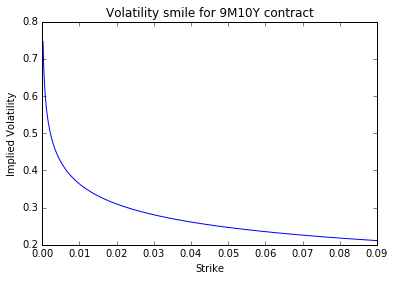

In [47]:
Strike_Range = np.linspace(0, 0.09, 400, endpoint=True)
ImpVol_1m1y = SABR(TimePer[0],Strike_Range,LiborForw[0],sigma[0],alpha[0],0.5,rho[0])
ImpVol_9m10y = SABR(TimePer[17],Strike_Range,LiborForw[17],sigma[17],alpha[17],0.5,rho[17])

plt.plot(Strike_Range,ImpVol_9m10y)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility smile for 9M10Y contract')
plt.show()

In [32]:
PVBP = []
PVBP.append(PVBasisPoint(0,Zero_Disc_1M))  #The 1m1y discount factors
PVBP.append(PVBasisPoint(1,Zero_Disc_1M))  #The 1m2y discount factors
PVBP.append(PVBasisPoint(2,Zero_Disc_1M))
PVBP.append(PVBasisPoint(4,Zero_Disc_1M))
PVBP.append(PVBasisPoint(9,Zero_Disc_1M))
PVBP.append(PVBasisPoint(0,Q_Zero_Disc_3M))  #The 3m1y discount factors
PVBP.append(PVBasisPoint(1,Q_Zero_Disc_3M))  #The 3m2y discount factors
PVBP.append(PVBasisPoint(2,Q_Zero_Disc_3M))
PVBP.append(PVBasisPoint(4,Q_Zero_Disc_3M))
PVBP.append(PVBasisPoint(9,Q_Zero_Disc_3M))
PVBP.append(PVBasisPoint(0,Q_Zero_Disc_6M))  #The 6m1y discount factors
PVBP.append(PVBasisPoint(1,Q_Zero_Disc_6M))  #The 6m2y discount factors
PVBP.append(PVBasisPoint(2,Q_Zero_Disc_6M))
PVBP.append(PVBasisPoint(4,Q_Zero_Disc_6M))
PVBP.append(PVBasisPoint(9,Q_Zero_Disc_6M))
PVBP.append(PVBasisPoint(1,Q_Zero_Disc_9M))  #The 9m2y discount factors
PVBP.append(PVBasisPoint(4,Q_Zero_Disc_9M))
PVBP.append(PVBasisPoint(9,Q_Zero_Disc_9M))

In [41]:
def SABR_VOL(T,K,S0,sig,alph,bet,ro):
    Imp_Vol = np.zeros((18,11))
    for i in range(18):
        for j in range(11):
            Imp_Vol[i][j] = SABR(T[i],K[i][j],S0[i],sig[i],alph[i],bet,ro[i])
    return Imp_Vol

def Black76_Price(T,K,F,Vol,BP):
    B76price = np.zeros((18,11))
    for i in range(18):
        for j in range(11):
            B76price[i][j] = BP[i]*Black76(T[i],K[i][j],F[i],Vol[i][j])
    return B76price

In [48]:
Implied_Volatilities = SABR_VOL(TimePer,Str,LiborForw,sigma,alpha,0.5,rho)

pd.DataFrame(Implied_Volatilities)

,0,1,2,3,4,5,6,7,8,9,10
0,0.351990,0.313632,0.289747,0.272659,0.265690,0.259487,0.253907,0.248846,0.239967,0.232380,0.225779
1,0.446358,0.398566,0.368576,0.347039,0.338238,0.330397,0.323339,0.316931,0.305681,0.296059,0.287680
2,0.456155,0.409766,0.380011,0.358405,0.349529,0.341599,0.334446,0.327939,0.316489,0.306671,0.298105
3,0.383127,0.349936,0.327280,0.310276,0.303173,0.296774,0.290961,0.285642,0.276213,0.268064,0.260910
4,0.340848,0.317359,0.300083,0.286536,0.280744,0.275462,0.270615,0.266141,0.258122,0.251108,0.244889
5,0.424328,0.378296,0.349576,0.329006,0.320612,0.313137,0.306412,0.300309,0.289599,0.280443,0.272473
6,0.460812,0.412097,0.381358,0.359219,0.350161,0.342083,0.334808,0.328200,0.316589,0.306652,0.297993
7,0.455756,0.410333,0.380953,0.359527,0.350705,0.342816,0.335692,0.329207,0.317784,0.307979,0.299417
8,0.388168,0.355234,0.332585,0.315514,0.308366,0.301920,0.296059,0.290691,0.281166,0.272924,0.265681
9,0.340107,0.316898,0.299779,0.286330,0.280574,0.275322,0.270500,0.266047,0.258063,0.251074,0.244874


In [49]:
Arbitrage_free_price = Black76_Price(TimePer,Str,LiborForw,Implied_Volatilities,PVBP)

pd.DataFrame(Arbitrage_free_price)

,0,1,2,3,4,5,6,7,8,9,10
0,0.078463,0.058847,0.039232,0.019630,0.010220,0.003238,0.000483,0.000030,7.392600e-09,6.746263e-14,3.493992e-20
1,0.154780,0.116085,0.077390,0.038871,0.021133,0.008188,0.002022,0.000300,1.398701e-06,9.490529e-10,1.180953e-13
2,0.228925,0.171694,0.114463,0.057594,0.031685,0.012786,0.003447,0.000591,4.369056e-06,5.753980e-09,1.646793e-12
3,0.370247,0.277685,0.185123,0.092952,0.050384,0.019270,0.004603,0.000642,2.382388e-06,1.106492e-09,8.107558e-14
4,0.680947,0.510711,0.340474,0.171170,0.093555,0.036797,0.009319,0.001425,6.912777e-06,4.537418e-09,4.903186e-13
5,0.078103,0.058577,0.039076,0.020406,0.012588,0.006743,0.003083,0.001193,1.083068e-04,5.226547e-06,1.425135e-07
6,0.154062,0.115547,0.077144,0.040930,0.025982,0.014680,0.007298,0.003175,4.035756e-04,3.097406e-05,1.503521e-06
7,0.227837,0.170879,0.114128,0.060853,0.038929,0.022291,0.011306,0.005054,6.918932e-04,5.861637e-05,3.205982e-06
8,0.368358,0.276270,0.184413,0.097426,0.061334,0.034090,0.016490,0.006890,7.726066e-04,4.917614e-05,1.862484e-06
9,0.677082,0.507816,0.339070,0.179737,0.113681,0.063637,0.031067,0.013117,1.500379e-03,9.669282e-05,3.659073e-06


## Comparison to the Displaced Diffusion model.

The SABR model gives us the Black76 implied volatilities. And we input that into the Black76 model to get the prices of the Swaption. Let us now compare this price with the price given by the displaced diffusion model. We shall calibrate volatility, Vol and the displaced diffusion parameter b using the prices found above.

In [36]:
def DisplcedDiffusion(T,K,F,Vol,BP,b):  #input b as a decimal
    DDprice = np.zeros((18,11))
    coeff = (1-b)/b
    for i in range(18):
        for j in range(11):
            DDprice[i][j] = BP[i]*Black76(T[i],K[i][j]+coeff*F[i],F[i]/b,Vol[i][j]*b)
    return DDprice

In [66]:
from scipy.optimize import root
#DDVol be the volatility to solve for
def root_fun_array(Param,T,K,F,BP,Price):
    coeff = (1-Param[1])/Param[1]
    fun_val = []
    fun_val.append(BP*Black76(T,K+coeff*F,F/Param[1],Param[0]*Param[1])- Price)
    fun_val.append(BP*Black76(T,K+coeff*F,F/Param[1],Param[0]*Param[1])- Price)
    return fun_val

DD_Vol = np.zeros((18, 11))
colms = range(11)
colms.pop(5)  #Exclude ATM price
DD_b=np.zeros((18,11))

start_value = np.array([0.001,0.5])

def Solve_Root(guess,T,K,F,BP,Price):
    for i in range(18):
        for j in colms:
            result = root(root_fun_array, guess, (T[i],K[i][j],F[i],BP[i],Price[i][j]), method = 'hybr')
            DD_Vol[i][j] = (result.x[0])
            DD_b[i][j] = (result.x[1])
    

In [67]:
Solve_Root(start_value,TimePer,Str,LiborForw,PVBP,Arbitrage_free_price) 

dfDD_Vol=pd.DataFrame(DD_Vol)
print dfDD_Vol

dfDD_b=pd.DataFrame(DD_b)
print dfDD_b

       0      1         2         3         4    5          6          7   \
0   0.001  0.001  0.001000  0.001000  0.001038  0.0   0.001000   0.001000   
1   0.001  0.001  0.001000  0.001064  0.001001  0.0   0.298664   0.001000   
2   0.001  0.001  0.001000  0.001000  0.001000  0.0   0.001000   0.001000   
3   0.001  0.001  0.001000  0.001000  0.001000  0.0   0.266437   0.001000   
4   0.001  0.001  0.001000  0.001000  0.001000  0.0   0.249113   0.001000   
5   0.001  0.001  0.001000  0.001000  0.001000  0.0   0.277248   0.001000   
6   0.001  0.001  0.001000  0.001000  0.001000  0.0   7.711076   0.001000   
7   0.001  0.001  0.001000  0.001000  0.001000  0.0   5.327473   0.311511   
8   0.001  0.001  0.001000  0.001245  0.001000  0.0   0.268791   0.273077   
9   0.001  0.001  0.001000  0.001000  0.001000  0.0   0.249870   0.256547   
10  0.001  0.001  0.001000  0.001000  0.001000  0.0  18.458346   0.308688   
11  0.001  0.001  0.001000  0.001000  0.001000  0.0  13.117544  18.560164   

In [59]:
root_fun_array(start_value,TimePer[0],Str[0][0],LiborForw[0],PVBP[0],Arbitrage_free_price[0][0])

1.3170890159654386e-09